<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20220917.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* customer analysis
* iterator

In [1]:
import pandas as pd 
import numpy as np
import plotnine as gg 
from plotnine import ggplot, aes 
from datetime import datetime, date, time, timezone, timedelta 
import os
import re 
from functools import reduce
from collections import defaultdict, ChainMap, Counter

# customer analysis

In [2]:
os.listdir()

['.config',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'online_retail_II.xlsx',
 'test.csv',
 'KPMG_VI_New_raw_data_update_final.csv',
 'ecommerce-data.csv',
 'sample_data']

In [5]:
df = pd.read_csv('ecommerce-data.csv', encoding = 'unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [8]:
df.columns = ['_'.join(re.split(r'(?=[A-Z][a-z])', a[0].lower() + a[1:])).lower() for a in df.columns]
df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [9]:
df = df[(~df.invoice_no.astype(str).str.contains('C')) & (df.country == 'United Kingdom')]
df.invoice_date = pd.to_datetime(df.invoice_date)
df['date'] = df.invoice_date.to_numpy().astype('datetime64[D]')
df['month'] = df.invoice_date.to_numpy().astype('datetime64[M]')
df['week'] = df['date'] - df['date'].dt.weekday.astype("timedelta64[D]")
df['rev'] = df.quantity * df.unit_price
df = df.rename(columns = {'customerid':'id', 'description':'desc'}).groupby(['id', 'desc', 'date','month','week'])['rev'].sum().reset_index()
df.head()


,id,desc,date,month,week,rev
0,12346.0,MEDIUM CERAMIC TOP STORAGE JAR,2011-01-18,2011-01-01,2011-01-17,77183.60
1,12747.0,3 DRAWER ANTIQUE WHITE WOOD CABINET,2011-11-17,2011-11-01,2011-11-14,17.90
2,12747.0,ASSORTED COLOUR BIRD ORNAMENT,2010-12-05,2010-12-01,2010-11-29,27.04
3,12747.0,ASSORTED COLOUR BIRD ORNAMENT,2010-12-13,2010-12-01,2010-12-13,40.56
4,12747.0,ASSORTED COLOUR BIRD ORNAMENT,2011-03-01,2011-03-01,2011-02-28,27.04


In [11]:
df['desc'].value_counts().reset_index().sort_values(['desc'], ascending = 0)

,index,desc
0,WHITE HANGING HEART T-LIGHT HOLDER,1856
1,JUMBO BAG RED RETROSPOT,1435
2,REGENCY CAKESTAND 3 TIER,1403
3,ASSORTED COLOUR BIRD ORNAMENT,1297
4,PARTY BUNTING,1285
...,...,...
3702,JET BLACK LAS VEGAS BRACELET ROUND,1
3703,WHITE STONE/CRYSTAL EARRINGS,1
3704,CHERRY BLOSSOM PURSE,1
3705,CURIOUS IMAGES SCRAP BOOK SET,1


In [24]:
df['desc'] = [a.strip() for a in df['desc']]

In [37]:
df = df.assign(flag = df['desc'].str.extract('\s([A-Z]{1,})$'))
df_ = df.groupby(['id', 'flag', 'date', 'week', 'month'])['rev'].sum().reset_index()
df_.head()

,id,flag,date,week,month,rev
0,12346.0,JAR,2011-01-18,2011-01-17,2011-01-01,77183.60
1,12747.0,ALPHABET,2011-10-04,2011-10-03,2011-10-01,20.80
2,12747.0,APPLES,2011-10-04,2011-10-03,2011-10-01,20.80
3,12747.0,ASSORTED,2010-12-05,2010-11-29,2010-12-01,13.52
4,12747.0,ASSORTED,2011-01-20,2011-01-17,2011-01-01,27.04


In [38]:
list_npu = df_.groupby(['id','flag'])['date'].min().reset_index().rename(columns = {'date':'npu_date'})
df_ = pd.merge(df_,list_npu, 'left', ['id','flag'])
df_

,id,flag,date,week,month,rev,npu_date
0,12346.0,JAR,2011-01-18,2011-01-17,2011-01-01,77183.60,2011-01-18
1,12747.0,ALPHABET,2011-10-04,2011-10-03,2011-10-01,20.80,2011-10-04
2,12747.0,APPLES,2011-10-04,2011-10-03,2011-10-01,20.80,2011-10-04
3,12747.0,ASSORTED,2010-12-05,2010-11-29,2010-12-01,13.52,2010-12-05
4,12747.0,ASSORTED,2011-01-20,2011-01-17,2011-01-01,27.04,2010-12-05
...,...,...,...,...,...,...,...
240014,18287.0,TOADSTOOLS,2011-05-22,2011-05-16,2011-05-01,17.70,2011-05-22
240015,18287.0,TREE,2011-10-12,2011-10-10,2011-10-01,14.04,2011-10-12
240016,18287.0,TREES,2011-10-12,2011-10-10,2011-10-01,52.20,2011-10-12
240017,18287.0,WINKIE,2011-10-12,2011-10-10,2011-10-01,39.60,2011-10-12


In [41]:
df_['days'] = (df_['date'] - df_['npu_date']).dt.days
cnt = df_.groupby(['flag', 'days'])['id'].count().reset_index().rename(columns = {"id":'pu'})
cnt['ratio'] = cnt.groupby(['flag'])['pu'].apply(lambda x : round(x/x.max()*100,2))
cnt = pd.melt(cnt, id_vars = ['flag', 'days'], var_name = 'type')
cnt.head()

,flag,days,type,value
0,A,0,pu,2.0
1,AHOY,0,pu,21.0
2,AHOY,4,pu,1.0
3,AIRMAIL,0,pu,86.0
4,AIRMAIL,8,pu,1.0


In [56]:
list_cnt = cnt['flag'].value_counts().reset_index().sort_values(['flag'], ascending = 0)
list_cnt = list_cnt.assign(ratio = [round(a/list_cnt['flag'].sum()*100,2 ) for a in list_cnt['flag']])
list_cnt = list_cnt[list_cnt['ratio'] >= 0.7]
list_cnt.head()

,index,flag,ratio
0,RETROSPOT,748,0.79
2,HOLDER,746,0.79
1,DESIGN,746,0.79
3,BOX,742,0.79
4,CASES,730,0.77


In [63]:
cnt[cnt['flag'].isin(list_cnt['index'])]

,flag,days,type,value
1382,BAG,0,pu,1295.00
1383,BAG,1,pu,2.00
1384,BAG,2,pu,4.00
1385,BAG,3,pu,3.00
1386,BAG,4,pu,1.00
...,...,...,...,...
93164,WHITE,361,ratio,0.19
93165,WHITE,362,ratio,0.09
93166,WHITE,364,ratio,0.09
93167,WHITE,368,ratio,0.09


/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet.py:393: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


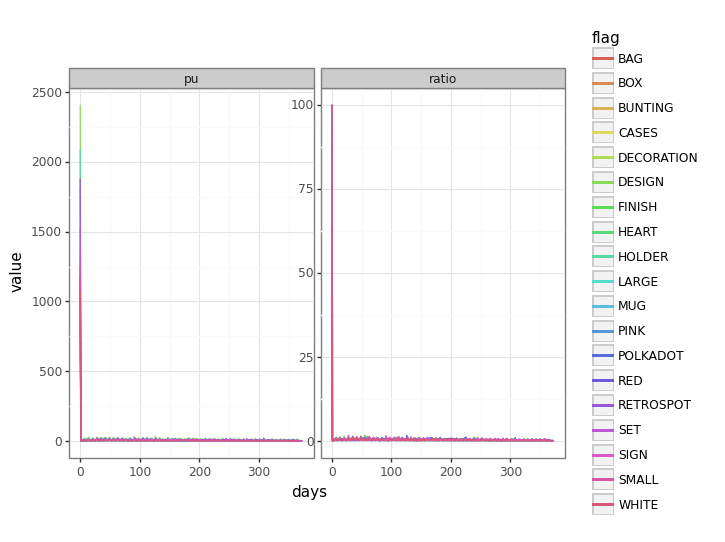

<ggplot: (8749606424921)>

In [64]:
(
    ggplot(cnt[cnt['flag'].isin(list_cnt['index'])], aes('days','value', color = 'flag')) +
    gg.geom_line() +
    gg.facet_wrap('~type', scales = 'free_y') +
    gg.theme_bw()
)

# iterator

In [70]:
mat = [list('ABC'), list('DEF'), list('GHI')]
a = [{letters : [r, c]} for r, rows in enumerate(mat) for c, letters in enumerate(rows)]
a

[{'A': [0, 0]},
 {'B': [0, 1]},
 {'C': [0, 2]},
 {'D': [1, 0]},
 {'E': [1, 1]},
 {'F': [1, 2]},
 {'G': [2, 0]},
 {'H': [2, 1]},
 {'I': [2, 2]}]

In [71]:
pd.DataFrame(a)

,A,B,C,D,E,F,G,H,I
0,"[0, 0]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,"[0, 1]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,"[0, 2]",NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,"[1, 0]",NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,"[1, 1]",NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,"[1, 2]",NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,"[2, 0]",NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[2, 1]",NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[2, 2]"


In [72]:
a

[{'A': [0, 0]},
 {'B': [0, 1]},
 {'C': [0, 2]},
 {'D': [1, 0]},
 {'E': [1, 1]},
 {'F': [1, 2]},
 {'G': [2, 0]},
 {'H': [2, 1]},
 {'I': [2, 2]}]

In [94]:
arr = np.empty([3,3], dtype = 'S10')
arr

array([[b'', b'', b''],
       [b'', b'', b''],
       [b'', b'', b'']], dtype='|S10')

In [95]:
arr[1,1]

b''

In [96]:
for x in a :  
  corr = list(x.values())[0]
  arr[corr[0], corr[1]] = list(x.keys())[0]
arr

array([[b'A', b'B', b'C'],
       [b'D', b'E', b'F'],
       [b'G', b'H', b'I']], dtype='|S10')

In [98]:
import time

In [99]:
time.time()

1663374240.2141042

In [137]:
def add_arthor_with_name(name) :
  def add_arthor(func) :
    def wrapper(*args, **kwargs) :
      return name + '\n' + func(*args, **kwargs)
    return wrapper
  return add_arthor

def calc_time(func) :
  def wrapper(*args, **kwargs) :
    a = time.time()
    func(*args, **kwargs)
    b = time.time()
    print(f'{b-a:.10f}')
    #return str((b-a))
  return wrapper

@calc_time
@add_arthor_with_name('kim')
def get_title(title) :
  return title

In [138]:
print(get_title('내 마지막 얘기'))

0.0000042915
None
